## Potential Talents - Part 5

----

# Fine Tune an LLM to retrieve most similar "Job Titles" with a "Query"

### Objective


### Constraints
- Local GPU: **GTX 1080 Ti**.

### Models (initial)
- **1:** `microsoft/phi-3-mini-4k-instruct` (4k context, small & GPU-friendly).
- **2:** `google/gemma-2-2b-it` (8k context, very small).
- **3:** `qwen2.5-3B-instruct` (32k context, ~3B params, list-style outputs).
- **4:** `moonshot/kimi-K2-(K2-0711)`
- **5:** `meta/llama-3.2-3B-Instruct`
- **6:** `deepseek/deepseek-v3.1-chat`
- **7:** `xai/grok-4-fast-reasoning`,`
- **8:** `openai/chatgpt-4o`
- (After some tests we will avoid FLAN-T5 here due to the ~512 token input limit.)

### Method
1)
2)
3)
4)
5)



----


### 0. Imports, configuration and folders

In [ ]:
# core
import os, json, gc
import numpy as np
import pandas as pd
import re, unicodedata
import torch
import random

# display config
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

In [5]:
# GPU configuration details
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [6]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# paths
DATA_DIR = "data"
OUT_DIR  = "outputs"

# datasets
base_ds_file = "potential_talents.csv"
extended_df_file = "Extended Dataset for Potential Talents.xlsx" 


### 1. Preprocessing and EAD

In [7]:
df = pd.read_excel(os.path.join(DATA_DIR,extended_df_file), engine="openpyxl")

In [8]:
df.head()

,id,title,location,screening_score
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1285 non-null   int64 
 1   title            1281 non-null   object
 2   location         1285 non-null   object
 3   screening_score  1285 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 40.3+ KB


In [10]:
def mem_in_mb(nbytes: int) -> str:
    return f"{nbytes / (1024**2):.2f} MB"

print("Shape:", df.shape)
print("Memory:", mem_in_mb(df.memory_usage(deep=True).sum()))


Shape: (1285, 4)
Memory: 0.25 MB


#### 1.1 Normalize the job titles

In [11]:
def normalize_text(s: str) -> str:
    # If the value is NaN/None (pandas missing), return empty string to standardize missing titles
    if pd.isna(s):
        return ""
    
    # Normalize Unicode to NFKC to fold compatibility chars (e.g., full-width forms) into canonical forms
    # Avoids false duplicates
    s = unicodedata.normalize("NFKC", str(s))
    
    # Remove zero-width space characters that can sneak into text and break equality checks
    s = s.replace("\u200b", "")
    
    # Collapse any run of whitespace (spaces, tabs, newlines) into a single space, then trim ends
    s = re.sub(r"\s+", " ", s).strip()
    
    return s

In [12]:
df['title_norm'] = df['title'].apply(normalize_text)
df['title_len'] = df['title'].str.len()

def alpha_ratio(s: str) -> float:
    # calculate the ratio between alpha and total characters
    if not s: return 0.0
    a = sum(ch.isalpha() for ch in s)
    return a / max(1,len(s))
df['alpha_ratio'] = df['title_norm'].apply(alpha_ratio)

In [13]:
df.head(5)

,id,title,location,screening_score,title_norm,title_len,alpha_ratio
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,119.0,0.865546
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,198.0,0.833333
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,122.0,0.885246
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,201.0,0.880597
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100,graduate research assistant at uab masters in data science student at uab ex jio,80.0,0.837500


#### 1.2 Identify "noisy job titles" and preview what would be dropped for the analysis

In [14]:
MIN_LEN = 2
MIN_ALPHA_RATIO = 0.25
# Bad tokens observed in the extended dataset
BAD_TOKENS = {
    "-", "--", "---", "—", "_", "n/a", "na", "none", "null", "untitled", "no title",
    "test", "dummy", ".", "?", "tbd", "todo"
}

In [15]:
# This pattern matches strings made only of punctuation/whitespace/symbols/underscores, with no letters or digits.
punct_only_re = re.compile(r"^[\W_]+$")

# Drop candidates: identify the positions where the condition is true for the following cases:
mask_empty = df["title_norm"].eq("")                                # empty after normalization
mask_bad_token  = df["title_norm"].str.lower().isin(BAD_TOKENS)     # exact match to a known junk token
mask_punct_only = df["title_norm"].str.match(punct_only_re)         # title is only punctuation/symbols/whitespace/_
mask_too_short = df["title_len"] < MIN_LEN                          # titles shorter than MIN_LEN
mask_low_alpha = df["alpha_ratio"] < MIN_ALPHA_RATIO                # too few alphabetic chars relative to total

# Combine all exclusion conditions (logical OR)
mask_nonrepr = mask_empty | mask_bad_token | mask_punct_only | mask_too_short | mask_low_alpha


In [16]:
from IPython.display import display

In [17]:
masks = {'mask_empty': mask_empty, 'mask_bad_token': mask_bad_token, 'mask_punct_only': mask_punct_only, 'mask_too_short': mask_too_short, 'mask_low_alpha': mask_low_alpha}

for mask_name, mask in masks.items():
    subset = df.loc[mask]
    print(f"\n{mask_name} — {subset.shape[0]} rows")
    display(subset.head(5))



mask_empty — 4 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
14,15,NaN,United States,100,,NaN,0.0
193,194,NaN,Austria,50,,NaN,0.0
248,249,NaN,United States,30,,NaN,0.0
587,588,NaN,United States,85,,NaN,0.0



mask_bad_token — 16 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
384,385,--,United States,100,--,2.0,0.0
431,432,--,United States,95,--,2.0,0.0



mask_punct_only — 16 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
384,385,--,United States,100,--,2.0,0.0
431,432,--,United States,95,--,2.0,0.0



mask_too_short — 1 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
175,176,.,United States,75,.,1.0,0.0



mask_low_alpha — 20 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
14,15,NaN,United States,100,,NaN,0.0
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
193,194,NaN,Austria,50,,NaN,0.0


In [18]:
print("Noisy job titles stats:")
print({    
    "empty": int(mask_empty.sum()),
    "bad_token": int(mask_bad_token.sum()),
    "punct_only": int(mask_punct_only.sum()),
    f"too_short(<{MIN_LEN})": int(mask_too_short.sum()),
    f"low_alpha(<{MIN_ALPHA_RATIO})": int(mask_low_alpha.sum()),
})

Noisy job titles stats:
{'empty': 4, 'bad_token': 16, 'punct_only': 16, 'too_short(<2)': 1, 'low_alpha(<0.25)': 20}


In [19]:
# drop empties + non-representative
df_clean = df.loc[~(mask_empty | mask_nonrepr)].copy()

In [20]:
# drop duplicates by normalized title
df_clean["title_key"] = df_clean["title_norm"].str.casefold()  #Casefolding is similar to lowercasing but more aggressive because it is intended to remove all case distinctions in a string
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=["title_key"], keep="first").copy()
after = len(df_clean)

In [21]:
print({
    "original_rows": len(df),
    "removed_empty_or_nonrepr": len(df) - len(df.loc[~(mask_empty | mask_nonrepr)]),
    "removed_duplicates": before - after,
    "final_rows": len(df_clean),
})

{'original_rows': 1285, 'removed_empty_or_nonrepr': 20, 'removed_duplicates': 66, 'final_rows': 1199}


In [22]:
# Drop helper cols
df_clean = df_clean.drop(columns=["title_key"])

In [23]:
df_clean.to_csv("extended_clean.csv")

In [24]:
df_clean.columns

Index(['id', 'title', 'location', 'screening_score', 'title_norm', 'title_len', 'alpha_ratio'], dtype='object')

#### 1.3 Character length distribution (titles only)

In [25]:
import matplotlib.pyplot as plt

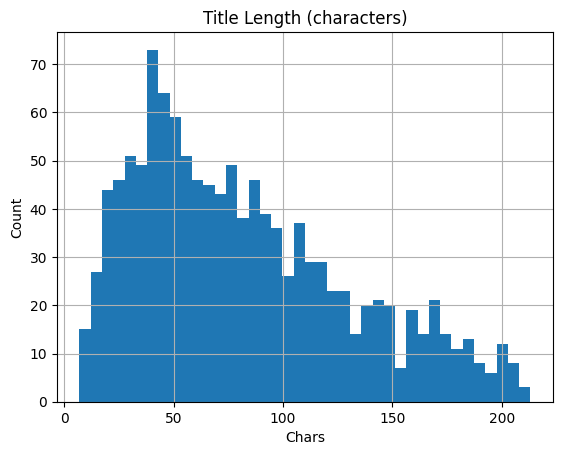

In [26]:
plt.figure()
df_clean["title_len"].hist(bins=40)
plt.title("Title Length (characters)")
plt.xlabel("Chars")
plt.ylabel("Count")
plt.show()

In [27]:
df_clean["title_len"].describe()


count    1199.000000
mean       81.874062
std        48.690361
min         7.000000
25%        43.000000
50%        72.000000
75%       112.500000
max       213.000000
Name: title_len, dtype: float64

### 2. Step 1: gross retrieving using Word Embedding (SBERT)

#### 2.1 import the SBERT model

In [29]:
from sentence_transformers import SentenceTransformer

In [30]:
text_col = "title_norm"
texts = df_clean[text_col].astype(str).tolist()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)
model.max_seq_length = 256  # plenty for the titles (max = 213 chars)

#### 2.2 Encode the titles

In [31]:
emb = model.encode(
    texts,
    batch_size=128,
    show_progress_bar=True,
    normalize_embeddings=True,      # cosine-ready
    convert_to_numpy=True
).astype(np.float32)

print("Shape:", emb.shape)          # (n_rows, 384)
print("Norm mean:", np.linalg.norm(emb, axis=1).mean())


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Shape: (1199, 768)
Norm mean: 1.0


In [32]:
# Copy the clean dataframe
df_model = df_clean.copy(deep=True)

In [33]:
# Create an immutable row index for embedding alignment
df_model = df_model.reset_index(drop=True)
df_model["emb_ix"] = df_model.index.astype("int32")

In [34]:
df_model.head()

,id,title,location,screening_score,title_norm,title_len,alpha_ratio,emb_ix
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,119.0,0.865546,0
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,198.0,0.833333,1
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,122.0,0.885246,2
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,201.0,0.880597,3
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100,graduate research assistant at uab masters in data science student at uab ex jio,80.0,0.837500,4


In [35]:
# Keep a slim view for joining results
meta_cols = ["emb_ix","id","title","title_norm"]
meta = df_model[meta_cols].copy()

#### 2.3 Retrieval function (encode query -> top-N by cosine similarity)

In [36]:
from typing import Union, Tuple

In [37]:
def retrieve_top_n(
    query: str,
    n: int = 50    
) -> pd.DataFrame:
    """
    Normalize + encode `query` with the same model, compute cosine similarities to `emb`,
    fully sort all items (O(N log N)), and return a DataFrame with the top-n results.

    Requires in scope:
      - normalize_text (function)
      - model (SentenceTransformer used to build `emb`)
      - emb   (np.ndarray, shape [N, D], L2-normalized rows)
      - meta  (DataFrame with columns including ['emb_ix','id','title','title_norm'])
    """
    # Normalize query text exactly like corpus titles
    q_text = normalize_text(query)
    
    # Encode query. Normalize to make cosine a dot product
    q = model.encode([q_text], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)[0]

    # Cosine similarities (dot product since vectors are L2-normalized)
    sims = emb @ q  # shape (N,)

    # Bound n and get indices of the top-n by full sort (O(N log N))
    N = sims.shape[0]
    n = int(max(1, min(n, N)))
    idx_sorted_desc = np.argsort(sims)[::-1][:n]  # full sort, take top-n

    # Build output DataFrame with originals
    out = meta.loc[idx_sorted_desc].copy()
    out.insert(0, "rank", np.arange(1, len(idx_sorted_desc) + 1))
    out["similarity"] = sims[idx_sorted_desc]
    return out.reset_index(drop=True)

Run some tests:

In [38]:
tests = [
    "machine learning engineer",
    "data scientist",
    "project manager"
]

for q in tests:
    print(f"\nQuery: {q}")
    display(retrieve_top_n(q, n=5))



Query: machine learning engineer


,rank,emb_ix,id,title,title_norm,similarity
0,1,891,947,machine learning engineer,machine learning engineer,1.000000
1,2,979,1039,machine learning engineer 2,machine learning engineer 2,0.864124
2,3,1140,1221,Data Scientist Machine Learning Engineer,Data Scientist Machine Learning Engineer,0.849322
3,4,1155,1237,Machine Learning Engineer Data Scientist MLOps,Machine Learning Engineer Data Scientist MLOps,0.841134
4,5,23,25,data analyst and machine learning engineer,data analyst and machine learning engineer,0.800220



Query: data scientist


,rank,emb_ix,id,title,title_norm,similarity
0,1,194,201,data scientist,data scientist,1.000000
1,2,1097,1173,data analyst data scientist,data analyst data scientist,0.918813
2,3,405,419,data scientist analyst,data scientist analyst,0.914789
3,4,1018,1080,data scientistgeoscientist,data scientistgeoscientist,0.880559
4,5,72,74,data analyst,data analyst,0.875535



Query: project manager


,rank,emb_ix,id,title,title_norm,similarity
0,1,707,738,program manager,program manager,0.648391
1,2,841,888,operations manager assistant program coordinator,operations manager assistant program coordinator,0.593523
2,3,1145,1227,Advanced Google Certified Data Analyst Project Manager,Advanced Google Certified Data Analyst Project Manager,0.573546
3,4,765,804,engineering supervisor,engineering supervisor,0.569864
4,5,697,727,performance marketing manager,performance marketing manager,0.549647


Sanity checks

In [41]:
qs = [
    "machine learning engineer",
    "data scientist",
    "project manager",
    "product manager",
    "ml ops engineer",
    "computer vision scientist",
]
rows = []
for q in qs:
    top5 = retrieve_top_n(q, n=5)
    rows.append({
        "query": q,
        "top1_title": top5.loc[0, "title"],
        "top1_sim": float(top5.loc[0, "similarity"])        
    })


In [42]:
pd.DataFrame(rows).sort_values("top1_sim")

,query,top1_title,top1_sim
2,project manager,program manager,0.648391
3,product manager,performance marketing manager,0.685709
5,computer vision scientist,computer scientist,0.735877
4,ml ops engineer,Machine Learning Engineer Data Scientist MLOps,0.761466
0,machine learning engineer,machine learning engineer,1.000000
1,data scientist,data scientist,1.000000


### 3. Step 2: fine retrieving using an LLM

For this second step we will use an LLM working as a ranker. Then, we will prepare a dataset to instruction fine tune the LLM.

#### 3.1 Build the dataset (CSV) to instruct fine tune the LLM

#### 3.1.1 Baseline: calculate the SBERT + cosine similarity and add it to a .csv file then used to fine tune the LLM

In [48]:
list_of_queries = ["machine learning engineer", "data scientist", "back end developer", "front end developer", "full stack engineer", "software architect", "devops engineer", "site reliability engineer", "mobile application developer", "cloud solutions architect", "project manager", "product manager", "program manager", "bid manager", "business analyst", "scrum master", "agile coach", "chief executive officer", "chief technology officer", "operations manager", "financial analyst", "investment banker", "accountant junior", "accountant taxes senior", "auditor", "chief financial officer", "controller", "tax advisor", "payroll specialist", "budget analyst", "attorney", "paralegal", "legal consultant", "human resources manager", "recruiter", "talent acquisition specialist", "marketing specialist", "digital marketing manager", "sales representative", "business development manager", "data researcher", "nuclear physicist", "atomic physicist", "biomedical researcher", "chemist", "astronomer", "registered nurse", "physician assistant", "clinical psychologist", "medical laboratory technician"]
print(f'Number of queries: {len(list_of_queries)}')

Number of queries: 50


In [ ]:
Now we will create a function to retrieve job candidates per querry following a balanced by bins considering the similarity score.

In [66]:
def retrieve_balanced_by_bins(
    query: str,
    total: int = 250,
    bin_edges: list[float] = [0.0, 0.2, 0.4, 0.6, 0.75, 0.85, 0.92, 0.97, 1.0],  # adjusted for a better balance
    per_bin: list[int] | None = None,
    min_per_bin: int = 10,
    shuffle_within_bin: bool = True,
    rng_seed: int = 23,
) -> pd.DataFrame:
    """
    Compute cosine sim for *all* titles, then sample roughly equal counts per bin.
    Returns a DataFrame like retrieve_top_n but with a 'bin' column.
    """
    q_text = normalize_text(query)
    if not q_text:
        return pd.DataFrame(columns=["rank","similarity","emb_ix","id","title","title_norm","bin"])

    q = model.encode([q_text], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)[0]
    sims = emb @ q  # (N,)

    # master table (descending rank for reference)
    order_desc = np.argsort(sims)[::-1]
    df_all = meta.loc[order_desc].copy()
    df_all["similarity"] = sims[order_desc]
    df_all["rank_desc"] = np.arange(1, len(df_all) + 1)

    # bin assignment
    bins = np.array(bin_edges, dtype=float)
    labels = [f"[{bins[i]:.2f},{bins[i+1]:.2f})" if i+1 < len(bins)-1 else f"[{bins[i]:.2f},{bins[i+1]:.2f}]"
              for i in range(len(bins)-1)]
    bin_idx = np.digitize(df_all["similarity"].to_numpy(), bins, right=False) - 1
    df_all["bin"] = pd.Categorical(
        [labels[i] if 0 <= i < len(labels) else "out" for i in bin_idx], categories=labels, ordered=True)

    # per-bin target counts
    n_bins = len(labels)
    if per_bin is None:
        base = total // n_bins
        per_bin = [max(min_per_bin, base)] * n_bins
        # new feature:
        # bonus for high bins (last 3 bins get +5 each)
        for j in range(-3, 0):
            per_bin[j] += 5
        # distribute remainder if any
        while sum(per_bin) > total:
            per_bin[0] -= 1  # trim from lowest bin
    else:
        assert len(per_bin) == n_bins, "per_bin must match number of bins"
        assert sum(per_bin) == total, "sum(per_bin) must equal total"

    rng = np.random.default_rng(rng_seed)
    pieces = []
    for lbl, k in zip(labels, per_bin):
        bin_df = df_all[df_all["bin"] == lbl]
        if len(bin_df) == 0:
            continue
        if shuffle_within_bin:
            bin_df = bin_df.sample(frac=1.0, random_state=rng.integers(0, 1_000_000))
        pieces.append(bin_df.head(min(k, len(bin_df))))
        
     # if we came up short (some bins were sparse), fill from nearest bins by descending rank
    balanced = pd.concat(pieces, ignore_index=True) if pieces else df_all.head(0)
    short = total - len(balanced)
    if short > 0:
        # exclude already picked. Fill by descending rank to ensure completion
        remaining = df_all.loc[~df_all.index.isin(balanced.index)]
        fill = remaining.head(short)
        balanced = pd.concat([balanced, fill], ignore_index=True)

    # sort for pretty output: by bin then by similarity desc    
    balanced = balanced.sort_values(["bin", "similarity"], ascending=[True, False]).reset_index(drop=True)
    # normalize to the output schema: add a 1..M rank column (not "top" rank, just display rank inside this set)
    balanced.insert(0, "rank", np.arange(1, len(balanced) + 1))
    # keep standard columns expected by your CSV builder
    cols = ["rank", "emb_ix", "id", "title", "title_norm", "similarity", "rank_desc", "bin"]
    
    return balanced[cols]

In [67]:
def sbert_cos_to_100(sim: float) -> int:
    """Map cosine similarity (0–1) to a 0–100 scale."""
    sim = float(np.clip(sim, 0.0, 1.0))
    return int(round(100 * sim))

def build_skeleton_csv(
    queries: list[str],
    N: int = 250,
    out_csv: str = "pairwise_llm_dataset_skeleton.csv"
) -> pd.DataFrame:
    """
    For each query:
      - retrieve_balanced_by_bins(query, total=N) -> balanced candidates
      - produce rows with SBERT cosine mapped to 0–100
      - leave LLM score columns empty (you will fill them later)
    """
    rows = []
    for q in queries:
        q_norm = normalize_text(q)
        cand = retrieve_balanced_by_bins(q_norm, total=N)  # balanced sampling
        for _, r in cand.iterrows():
            rows.append({
                "query": q,
                "query_norm": q_norm,
                "id": r["id"],
                "emb_ix": int(r["emb_ix"]),
                "title": r["title"],
                "title_norm": r.get("title_norm", r["title"]),
                "emb_rank": int(r["rank"]),                   # rank inside balanced sample
                "emb_rank_desc": int(r["rank_desc"]),         # global descending rank
                "bin": r["bin"],                              # bin label for traceability
                "emb_score": float(r["similarity"]),          # cosine (0–1)
                "emb_score_100": sbert_cos_to_100(r["similarity"]),
                # LLM scores (fill later)
                "llm_score_v1": np.nan,
                "llm_score_v2": np.nan,
                "llm_score_v3": np.nan,
                # Aggregates (compute later)
                "llm_score_median": np.nan,
                "llm_score_iqr": np.nan,
                "final_weighted": np.nan,
                "needs_review": np.nan,
                "notes": ""
            })
    df_csv = pd.DataFrame(rows)
    df_csv.to_csv(out_csv, index=False)
    print(f"Skeleton saved: {out_csv} | rows: {len(df_csv)}")
    return df_csv


In [68]:
# prepare the csv first version
df_ft_ds = build_skeleton_csv(
    list_of_queries,
    N=250) 

Skeleton saved: pairwise_llm_dataset_skeleton.csv | rows: 12500


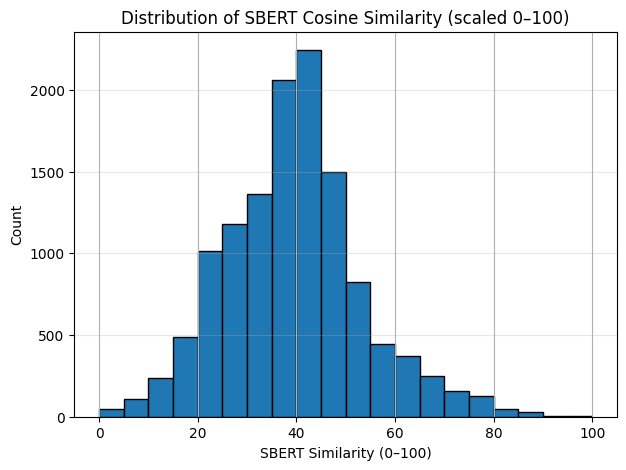

In [70]:
# plot the embedding scores histogram 
plt.figure(figsize=(7,5))
df_ft_ds["emb_score_100"].hist(bins=20, edgecolor="black")
plt.title("Distribution of SBERT Cosine Similarity (scaled 0–100)")
plt.xlabel("SBERT Similarity (0–100)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


#### 3.1.2 First LLM score: add a second score from the LLM

In [72]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [73]:
# load once
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
tok = AutoTokenizer.from_pretrained(MODEL_ID, token=os.getenv("HF_TOKEN"), use_fast=True)


In [74]:
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    token=os.getenv("HF_TOKEN"),
).eval()
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
# Prompt v1: pairwise single candidate
def build_prompt_v1(query: str, title: str) -> str:
    return (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Return EXACTLY one integer 0–100.\n"
        "Scale:\n"
        " • 90–100 = exact/near-exact\n"
        " • 70–89  = very similar\n"
        " • 40–69  = related/adjacent\n"
        " • 10–39  = mostly unrelated\n"
        " • 0–9    = unrelated\n"
        "Return the integer ONLY (no words, no punctuation, no decimals).\n\n"
        f'Query: "{query}"\nCandidate:\n{title}'
    )

def parse_one_int(text: str) -> int:
    m = re.findall(r"-?\d+", text)
    if not m:
        return 0
    x = int(m[-1])
    return max(0, min(100, x))

def score_one_pair(query: str, title: str, build_prompt_fn=build_prompt_v1, max_new_tokens: int = 6) -> int:
    """
    Score a (query, title) pair with LLaMA using the given prompt builder.
    
    Args:
        query (str): input query string
        title (str): candidate job title
        build_prompt_fn (callable): function (query, title) -> str, builds the prompt
        max_new_tokens (int): generation length, defaults to 6
    Returns:
        int: similarity score 0–100
    """
    
    prompt = build_prompt_fn(query, title)
    inputs = tok(prompt, return_tensors="pt").to(mdl.device)
    with torch.no_grad():
        out_ids = mdl.generate(
            **inputs,
            do_sample=False,
            num_beams=1,
            max_new_tokens=max_new_tokens,
            pad_token_id=tok.eos_token_id,
            use_cache=True,
        )
    out_txt = tok.decode(out_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return parse_one_int(out_txt)


In [78]:
score = score_one_pair("machine learning engineer", "data scientist")
print("Score:", score)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Score: 0
